In [1]:
# installing libraries and updating to latest version, if any

import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    %pip install -Uqq fastai duckduckgo_search

In [20]:
from fastcore.all import *
from duckduckgo_search import DDGS
from fastdownload import download_url
from fastai.vision.all import *
from time import sleep

def search_images(term, max_images=200):
    print(f"Searching for '{term}'")
    with DDGS(headers = {"Accept-Encoding": "gzip, deflate, br"}) as ddgs:
        results = ddgs.images(keywords=term, max_results=max_images)
        return L(results).itemgot('image')
    
queries = ("good+road","bad+road")
path = Path("road_types")

for i in queries:
    dest = path/i
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(i))
    resize_images(dest, max_size=400, dest=dest)

# clean up
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(f"cleaned up {len(failed)} images that failed to download properly")


Searching for 'good+road'
Searching for 'bad+road'
cleaned up 11 images that failed to download properly


Now time for training

epoch,train_loss,valid_loss,error_rate,time
0,0.831710,0.270112,0.123457,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.387996,0.202785,0.074074,00:01
1,0.237313,0.189043,0.098765,00:01
2,0.161558,0.190309,0.086420,00:01
3,0.114801,0.181878,0.086420,00:01
4,0.088619,0.179871,0.061728,00:01


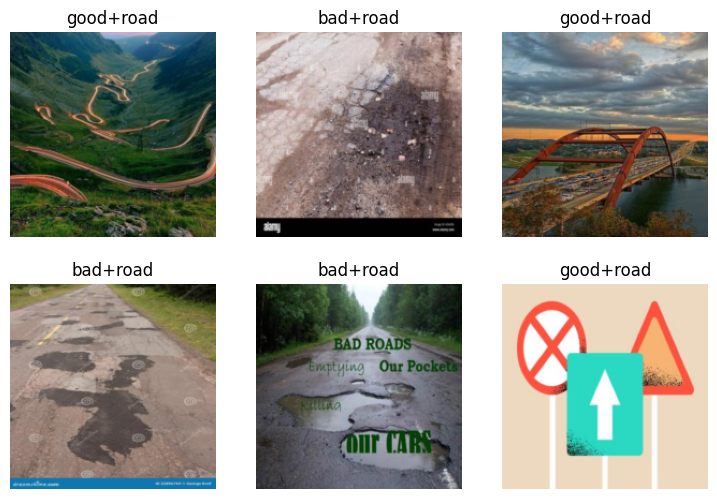

In [21]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

Now we put our model to work.

Searching for 'random road photo'


good+road with a probability of 0.0643


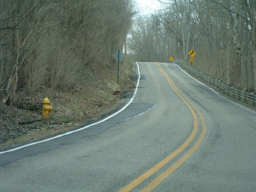

In [27]:
test_image = search_images("random road photo", max_images=1)
test_image = download_url(test_image[0])

results,_,probs = learn.predict(PILImage.create(Image.open(test_image).to_thumb(256,256)))
print(results, f"with a probability of {probs[0]:.4f}")
Image.open(test_image).to_thumb(256,256)